## Lab: Deep Learning with Normalization & Regularization

### Step 0: Import Libraries and Load the Dataset

In [1]:
# CodeGrade step0

# 1. Import Libraries and Load the Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2026-02-02 20:13:04.347196: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Step 1: Load and Preprocess the Data

Replace the `None`s appropriately.

In [2]:
# CodeGrade step1

# Load Breast Cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Create Training, Validation, and Test Splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Normalize the Data
scaler = StandardScaler()
scaler.fit(X_train_final)

X_train_scaled = scaler.transform(X_train_final)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)




# Shapes and class distribution
X.shape,  y.shape, np.bincount(y), X_train_final.shape, X_val.shape, X_test.shape, X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape


((569, 30),
 (569,),
 array([212, 357]),
 (364, 30),
 (91, 30),
 (114, 30),
 (364, 30),
 (91, 30),
 (114, 30))

### Step 2: Build a Baseline Model

* Create a sequential model using Keras.

* Add a dense layer with 32 neurons, using the ReLU activation function and set the input shape to match the number of features in your training dataset.

* Add a second dense layer with 16 neurons, again using the ReLU activation function.

* Add a final dense layer with 1 neuron and a sigmoid activation function to produce a binary classification output.

* Compile the model by specifying the Adam optimizer, binary crossentropy as the loss function, and include accuracy as a metric.

* Fit the model using your scaled training data and corresponding labels, and provide the scaled validation data for performance monitoring. Set the training to run for 50 epochs with a batch size of 32 and keep the output minimal by setting verbosity to 0.

* Evaluate the trained model on the scaled validation data to obtain the validation loss and accuracy.

* Verify that the validation accuracy, when rounded to two decimal places, exceeds 90%.

In [7]:
# CodeGrade step2

# Build a Baseline Model (No BatchNorm or Regularization)
baseline_model = tf.keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)), # should shape be on scaled?
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history_baseline = baseline_model.fit(
    X_train_scaled, y_train_final,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    verbose=0
)

# Evaluate Baseline on Validation
val_loss_base, val_acc_base = baseline_model.evaluate(X_val_scaled, y_val, verbose=0)
round(val_acc_base,2) > 0.9

True

### Step 3: Integrate Batch Normalization

- Create a sequential model using TensorFlow’s Keras API.
- Add a dense layer with 32 neurons, using a linear activation function, and specify the input shape to match your training data.
- Immediately add a Batch Normalization layer to standardize the outputs from the previous layer.
- Follow this with an Activation layer applying the ReLU activation function.
- Add another dense layer with 16 neurons, using a linear activation function.
- Again, insert a Batch Normalization layer after the dense layer.
- Add another Activation layer with ReLU to introduce non-linearity.
- Add a final dense layer with 1 neuron and a sigmoid activation function to provide a binary output.
- Compile the model using the Adam optimizer, binary crossentropy as the loss function, and include accuracy as a performance metric.
- Train (fit) the model using the scaled training data and the corresponding labels, and use the scaled validation data to monitor performance during training. Set the training to run for 50 epochs with a batch size of 32 and minimal verbosity.
- Evaluate the trained model on the scaled validation data to obtain the loss and accuracy.
- Ensure that the validation accuracy, when rounded to two decimal places, exceeds 90%.

In [8]:
# CodeGrade step3

# Integrate Batch Normalization
model_bn = tf.keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(32,activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(16, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1, activation='sigmoid')
])

model_bn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_bn = model_bn.fit(
    X_train_scaled, y_train_final,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    verbose=0
)

# Evaluate BN Model on Validation
val_loss_bn, val_acc_bn = model_bn.evaluate(X_val_scaled, y_val, verbose=0)
round(val_acc_bn,2) > 0.9


True

### Step 4: Add L2 Regularization and Dropout

- Define the regularization parameters: set the L2 regularization factor (l2_reg) to 1e-4 and the dropout rate to 0.3.
- Create a sequential model using TensorFlow’s Keras API.
- Add a dense layer with 32 neurons and ReLU activation, applying L2 regularization to its weights, and set the input shape to match the training data.
- Insert a Dropout layer with the specified dropout rate to randomly disable a fraction of the neurons.
- Add a second dense layer with 16 neurons and ReLU activation, also applying L2 regularization to its weights.
- Follow this with another Dropout layer using the same dropout rate.
- Add a final dense layer with 1 neuron and a sigmoid activation function for binary classification output.
- Compile the model using the Adam optimizer, binary crossentropy as the loss function, and include accuracy as a metric.
- Train the model using the scaled training data and corresponding labels, while validating on the scaled validation data. Set the training to run for 50 epochs with a batch size of 32 and minimal verbosity.
- Evaluate the trained model on the validation data to obtain the loss and accuracy.
- Confirm that the validation accuracy, when rounded to two decimal places, exceeds 90%.

In [11]:
# CodeGrade step4

# Add L2 Regularization and Dropout
l2_reg = 1e-4
dropout_rate = 0.3

model_reg = tf.keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(32,
                 activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)
                ),

    layers.Dropout(dropout_rate),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)
                ),

    layers.Dense(1, activation='sigmoid')
])

model_reg.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history_reg = model_reg.fit(
    X_train_scaled, y_train_final,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    verbose=0
)

# Evaluate Regularized Model on Validation
val_loss_reg, val_acc_reg = model_reg.evaluate(X_val_scaled, y_val, verbose=0)
round(val_acc_reg,2) > .9

True

### Step 5: Evaluate the Best Model on the Test Set and Visualize Performance

- Evaluate the regularized model on the test set by calling the model’s evaluate method with the scaled test features (X_test_scaled) and test labels (y_test), and set verbosity to 0 to suppress detailed output.
- Capture the resulting test loss and test accuracy in the variables test_loss_reg and test_acc_reg, respectively.
- Round the test accuracy (test_acc_reg) to two decimal places.
- Check that the rounded test accuracy is greater than 90% (i.e., exceeds 0.9) to ensure the model meets the performance threshold on the test data.

In [17]:
# print("=== Baseline Model ===")
# train_scores = baseline_model.evaluate(X_train_scaled, y_train_final, verbose=0)
# val_scores   = baseline_model.evaluate(X_val_scaled, y_val, verbose=0)
# print(f"Train Loss: {train_scores[0]:.4f}, Train Accuracy: {train_scores[1]:.4f}")
# print(f"Val   Loss: {val_scores[0]:.4f}, Val   Accuracy: {val_scores[1]:.4f}")

# print("\n=== BatchNorm Model ===")
# train_scores_bn = model_bn.evaluate(X_train_scaled, y_train_final, verbose=0)
# val_scores_bn   = model_bn.evaluate(X_val_scaled, y_val, verbose=0)
# print(f"Train Loss: {train_scores_bn[0]:.4f}, Train Accuracy: {train_scores_bn[1]:.4f}")
# print(f"Val   Loss: {val_scores_bn[0]:.4f}, Val   Accuracy: {val_scores_bn[1]:.4f}")

# print("\n=== Regularized Model (L2 + Dropout) ===")
# train_scores_reg = model_reg.evaluate(X_train_scaled, y_train_final, verbose=0)
# val_scores_reg   = model_reg.evaluate(X_val_scaled, y_val, verbose=0)
# print(f"Train Loss: {train_scores_reg[0]:.4f}, Train Accuracy: {train_scores_reg[1]:.4f}")
# print(f"Val   Loss: {val_scores_reg[0]:.4f}, Val   Accuracy: {val_scores_reg[1]:.4f}")

In [12]:
# CodeGrade step5


# Compare Best Model on Test Set
# Example: Use the Regularized Model on Test
test_loss_reg, test_acc_reg = model_reg.evaluate(X_test_scaled, y_test, verbose=0)
round(test_acc_reg,2) > 0.9

True

Plot Accuracy Over Epochs for the Regularized Model

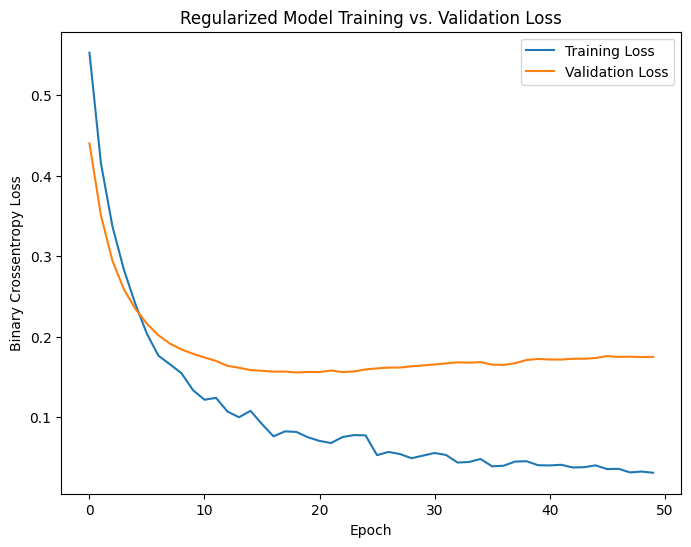

In [16]:
# Plot Accuracy Over Epochs for the Regularized Model
plt.figure(figsize=(8,6))
plt.plot(history_reg.history['loss'], label='Training Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.title('Regularized Model Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()
plt.show()

